## Time Series Regression Models

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
#parse datetime with weird timezone format
def parse_datetime_with_timezone(dt_str):
    datetime_str = dt_str[:-3] + dt_str[-2:]
    return pd.to_datetime(datetime_str, utc=True, format="%Y-%m-%d %H:%M:%S%z")

# TODO RE-Write without using "date_parser"
df = pd.read_csv("LMPSWide2023.csv", parse_dates=['Time'], date_parser=parse_datetime_with_timezone, index_col='Time')

# Make sure this is the right timezone 
df.index = df.index.tz_convert('America/New_York')

#Set the frequency
#we need to do this before using in STL 
df= df.asfreq(freq='h')

C:\Users\U1231034\AppData\Local\Temp\ipykernel_24224\1879699630.py:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv("LMPSWide2023.csv", parse_dates=['Time'], date_parser=parse_datetime_with_timezone, index_col='Time')


In [3]:
df.drop(columns=["KCPLIATANUNIAT2","KCPLLACYGNEUNLAC2","SECI.KCPS.CIMARRON", "WR.LEC.4", "WR.JEC.2", "WR.JEC.3", "SECI.KCPS.CIMARRON"], inplace=True)

### Linear Models- Ordinary Least Squares
Let's us weather data as the predictor and LMPS from Cimarron wind farm

In [4]:
cimarron=df[["SECI_CIMARRON"]]
cimarron.head()

,SECI_CIMARRON
Time,
2023-01-01 01:00:00-05:00,17.3592
2023-01-01 02:00:00-05:00,17.1675
2023-01-01 03:00:00-05:00,18.5753
2023-01-01 04:00:00-05:00,18.0899
2023-01-01 05:00:00-05:00,18.7861


In [5]:
#Get the weather data
weather = pd.read_csv("CimarronWeather23.csv")
weather.head()

,time,temperature,wind_speed
0,2023-01-01T00:00,4.4,31.3
1,2023-01-01T01:00,3.5,28.7
2,2023-01-01T02:00,2.6,25.7
3,2023-01-01T03:00,3.1,28.7
4,2023-01-01T04:00,3.1,28.9


In [6]:
cimarron["temp"]=weather["temperature"].values
cimarron["wind"]=weather["wind_speed"].values

C:\Users\U1231034\AppData\Local\Temp\ipykernel_24224\145142433.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cimarron["temp"]=weather["temperature"].values
C:\Users\U1231034\AppData\Local\Temp\ipykernel_24224\145142433.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cimarron["wind"]=weather["wind_speed"].values


Hold back the last week as the final test set

In [7]:
cimarron_train = cimarron.iloc[:-168]
cimarron_train.tail()

,SECI_CIMARRON,temp,wind
Time,,,
2023-12-24 20:00:00-05:00,-17.8339,2.0,50.4
2023-12-24 21:00:00-05:00,-18.6550,1.7,48.7
2023-12-24 22:00:00-05:00,-19.9816,0.1,48.3
2023-12-24 23:00:00-05:00,-21.0681,-0.3,47.8
2023-12-25 00:00:00-05:00,-23.4609,-0.9,48.7


<Axes: xlabel='Time'>

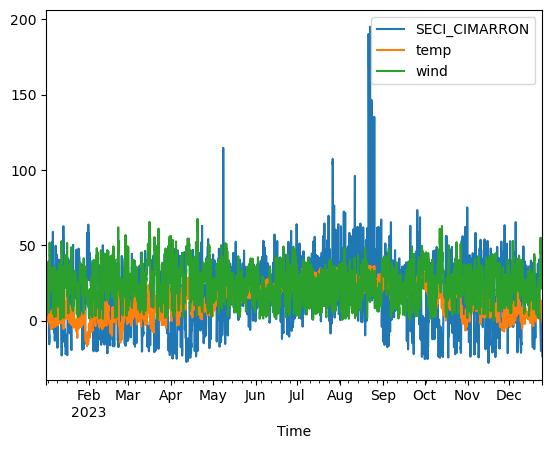

In [9]:
cimarron_train.plot()

<Axes: xlabel='Time'>

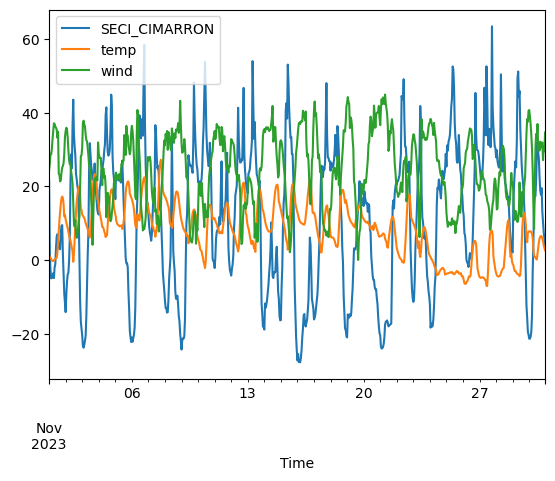

In [54]:
cimarron.loc["2023-11"].plot()

In [8]:
cimarron_test = cimarron.iloc[-168:]

In [9]:
X=cimarron_train.drop("SECI_CIMARRON", axis="columns")

In [10]:
X.shape

(8592, 2)

In [11]:
y=cimarron_train.drop(["temp", "wind"], axis="columns")

In [12]:
y.shape

(8592, 1)

In [13]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn import linear_model

In [14]:
import statsmodels.api as sm

In [15]:
X = sm.add_constant(X)

Let's try it in SciKitLearn first

In [16]:
#set up training and tests sets
#gap of 2 days between train and test splits
#try max train 6500 (~80% of data)
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=6500,
    test_size=500,
)

In [17]:
ols = linear_model.LinearRegression(fit_intercept=False)

In [18]:
cv_results = cross_validate(ols, X, y, cv=ts_cv, scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error", "r2"], return_estimator=True) 

In [19]:
mae = -cv_results["test_neg_mean_absolute_error"]
rmse = -cv_results["test_neg_root_mean_squared_error"]
r2 = cv_results["test_r2"]
print(
    f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
    f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}\n"
    f"R Squared: {r2.mean():.3f} +/- {rmse.std():.3f}")

Mean Absolute Error:     12.160 +/- 1.099
Root Mean Squared Error: 15.146 +/- 1.258
R Squared: 0.363 +/- 1.258


In [20]:
for reg in cv_results["estimator"]:
    print (reg.coef_)

[[38.8200968   0.36381389 -1.09662218]]
[[38.79938263  0.33810403 -1.09517704]]
[[38.59089688  0.34508407 -1.11853572]]
[[37.06399075  0.40241042 -1.11781534]]
[[38.80949697  0.35357329 -1.14724296]]


Now we do it in StatsModels

In [16]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          SECI_CIMARRON   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     3065.
Date:                Thu, 29 Aug 2024   Prob (F-statistic):               0.00
Time:                        11:24:41   Log-Likelihood:                -35562.
No. Observations:                8592   AIC:                         7.113e+04
Df Residuals:                    8589   BIC:                         7.115e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.6287      0.459     88.438      0.0

#### Fitted Values

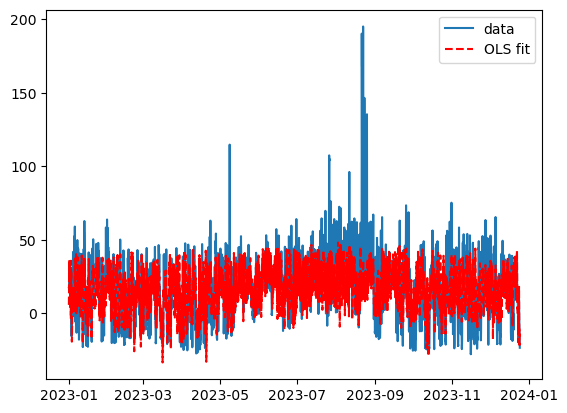

In [29]:
fig,ax=plt.subplots()
ax.plot(y, label='data')
ax.plot(results.fittedvalues, "r--", label="OLS fit")
ax.legend(loc='best')

In [40]:
compdf = y
compdf.reset_index(drop=True,inplace=True)

In [41]:
compdf['Fitted']=results.fittedvalues.values

In [42]:
compdf.head()

,SECI_CIMARRON,Fitted
0,17.3592,5.755060
1,17.1675,8.522165
2,18.5753,11.748589
3,18.0899,8.425067
4,18.7861,8.195407


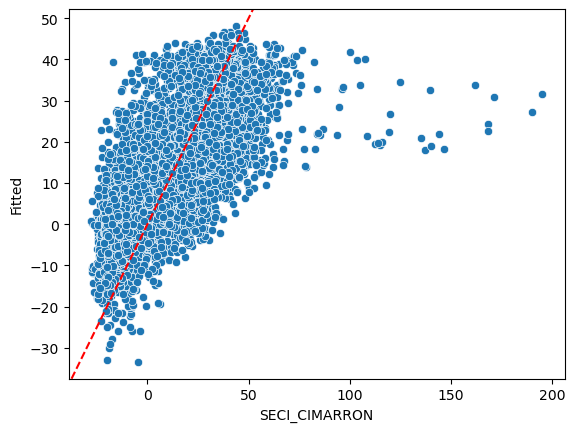

In [44]:
sns.scatterplot(data = compdf, x="SECI_CIMARRON", y="Fitted")
plt.gca().axline((0, 0), slope=1, color='red', linestyle='--')
plt.show()

* R2 squared valued is .41, so the model caputres less than half of the variance in the data
* fitted values show how the model is limited in capturing the high variance price
* This model is not good at all, but this is more of an excercise in setting the model up and understanding the scores
https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

### Evaluating The Regression Model

<Axes: xlabel='Time'>

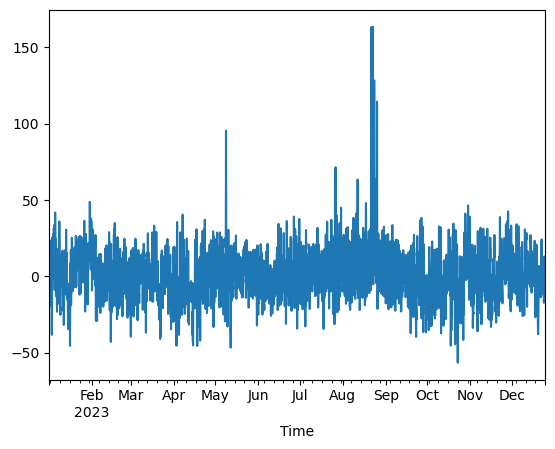

In [17]:
#Plot Residuals
results.resid.plot()

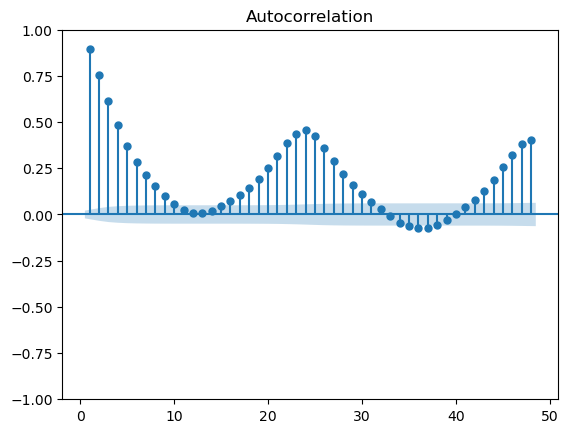

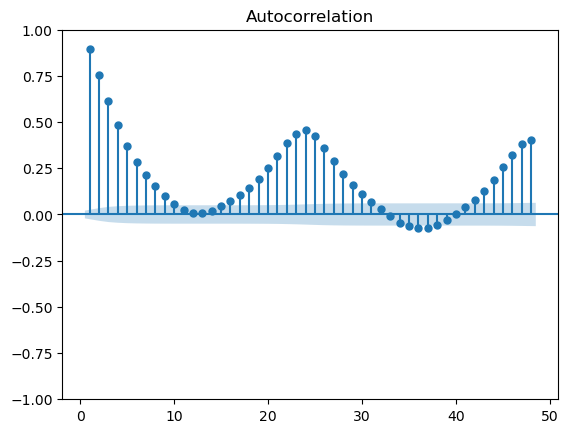

In [21]:
#ACF Plot of Residuals
sm.graphics.tsa.plot_acf(results.resid, zero=False, lags=48)

Strong autocorrelatoin of the residuals indicatse that are model is inefficient and there is more informatoin which should be captured

<Axes: ylabel='Count'>

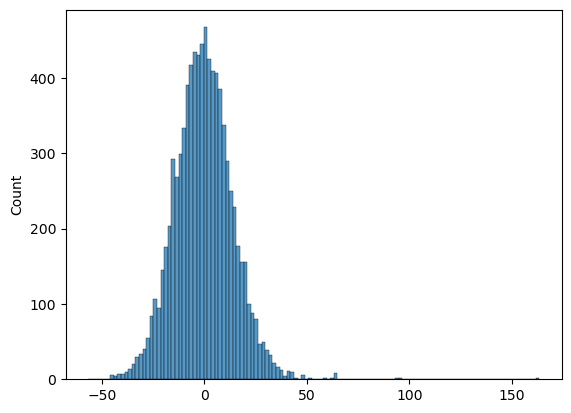

In [23]:
sns.histplot(results.resid)

In [24]:
cimarron_res = cimarron_train

In [28]:
cimarron_res["fitted"]=results.fittedvalues.values
cimarron_res["resid"]=results.resid.values
cimarron_res.head()

C:\Users\U1231034\AppData\Local\Temp\ipykernel_24224\3034282725.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cimarron_res["fitted"]=results.fittedvalues.values
C:\Users\U1231034\AppData\Local\Temp\ipykernel_24224\3034282725.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cimarron_res["resid"]=results.resid.values


,SECI_CIMARRON,temp,wind,fitted,resid
Time,,,,,
2023-01-01 01:00:00-05:00,17.3592,4.4,31.3,5.755060,11.604140
2023-01-01 02:00:00-05:00,17.1675,3.5,28.7,8.522165,8.645335
2023-01-01 03:00:00-05:00,18.5753,2.6,25.7,11.748589,6.826711
2023-01-01 04:00:00-05:00,18.0899,3.1,28.7,8.425067,9.664833
2023-01-01 05:00:00-05:00,18.7861,3.1,28.9,8.195407,10.590693


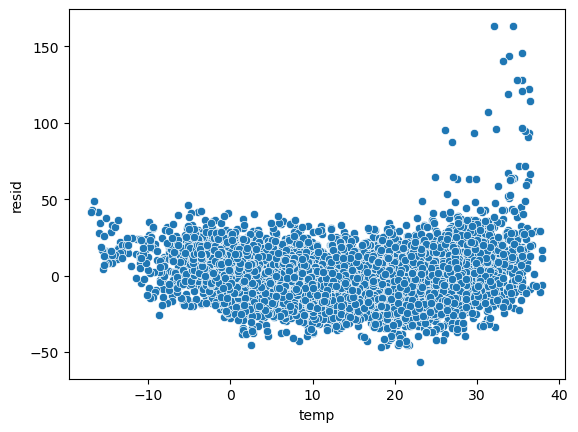

In [31]:
sns.scatterplot(data = cimarron_res, x="temp", y="resid")
plt.show()

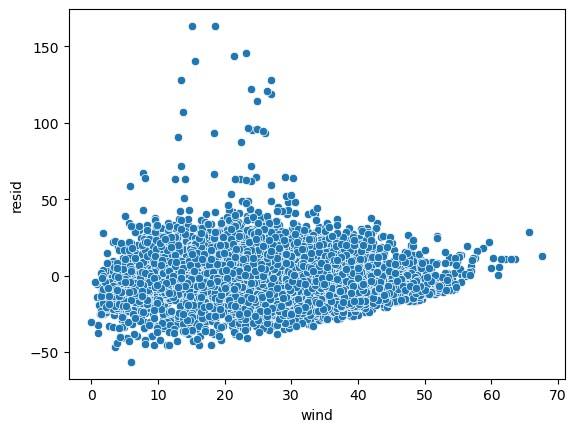

In [32]:
sns.scatterplot(data = cimarron_res, x="wind", y="resid")
plt.show()

Residuals plotted against the predictors look to be unrandom. The plots do show a pttern and the relatoinship maybe nonlinear. we should try a transformatoin or a nonlinear regression

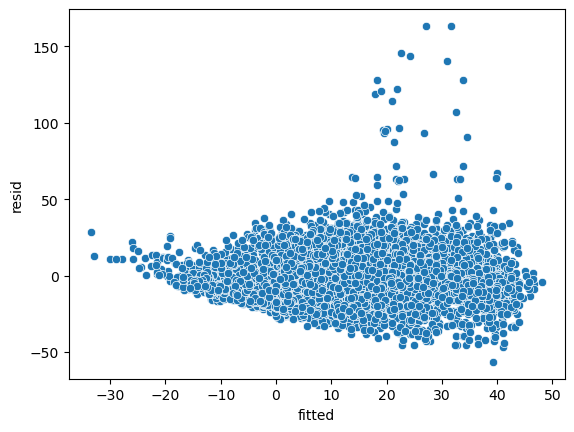

In [33]:
#HETERSCEDASTICITY
sns.scatterplot(data = cimarron_res, x="fitted", y="resid")
plt.show()

the varinace clearly increases and shows strong heteroscedasticty

### General Workflow
* pre-process data: pipeline
* split data into training and test set: pandas slicing
* set up cross validation on train set: TimeSeriesSplit
* Model tuning and evaluation: cross_validate
* ?Evaluate model on test set?

In [ ]:
# Ordinary Least Squares
# https://scikit-learn.org/stable/modules/linear_model.html